# Herramienta Geo Estadística para el Seguimiento de la Deforestación de la Procuraduría General de la Nación (HGESD-PGN)

In [1]:
# Librerias a usar
import os
import shutil
import pandas as pd
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import mapping
from shapely.geometry import LineString

from pyproj import Transformer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
from gap_statistic import OptimalK

from scipy.stats import norm

## Lectura de datos y creación de carpetas para alojar la información

In [4]:
# Trimestre a trabajar
trimestre='i'
año='2024'

# Lectura y tratamiento de rchivos KML
ArchivoAT=f'atd_{año}_{trimestre}_trim.kml'

#Se ubica la temporalidad año_trimestre
Temporalidad=año+trimestre

gdf = gpd.read_file(ArchivoAT, driver='KML')
coords = gdf.geometry.apply(lambda p: [p.x, p.y]).tolist()
gdf.shape

(21577, 3)

In [4]:
#Crear carpetas para almacenar los archivos
Carpeta_resultados='Resultados_'+Temporalidad

Carpeta_clusters=f'{Carpeta_resultados}'+'/Clusters_'+Temporalidad
Carpeta_centroide=f'{Carpeta_resultados}'+'/Centroides_'+Temporalidad
Carpeta_PoligonosMinimos=f'{Carpeta_resultados}'+'/PoligonosMinimos_'+Temporalidad
Carpeta_CirculosMáximos=f'{Carpeta_resultados}'+'/CirculosMáximos_'+Temporalidad
Carpeta_CirculosMínimos=f'{Carpeta_resultados}'+'/CirculosMínimos_'+Temporalidad
Carpeta_LineasDeTendencia=f'{Carpeta_resultados}'+'/LineasDeTendencia_'+Temporalidad

Carpeta_Graficas=f'{Carpeta_resultados}'+'/Graficas_'+Temporalidad

    # Se verifica que no existan carpetas ya creadas e información solapada
if os.path.exists(Carpeta_resultados):
    shutil.rmtree(Carpeta_resultados)
if os.path.exists(Carpeta_clusters):
    shutil.rmtree(Carpeta_clusters)
if os.path.exists(Carpeta_centroide):
    shutil.rmtree(Carpeta_centroide)
if os.path.exists(Carpeta_PoligonosMinimos):
    shutil.rmtree(Carpeta_PoligonosMinimos)
if os.path.exists(Carpeta_CirculosMáximos):
    shutil.rmtree(Carpeta_CirculosMáximos)
if os.path.exists(Carpeta_CirculosMínimos):
    shutil.rmtree(Carpeta_CirculosMínimos)
if os.path.exists(Carpeta_LineasDeTendencia):
    shutil.rmtree(Carpeta_LineasDeTendencia)
if os.path.exists(Carpeta_Graficas):
    shutil.rmtree(Carpeta_Graficas)

    #Se crean nuevas carpetas con las información
if Carpeta_resultados not in os.listdir():
    os.mkdir(Carpeta_resultados)
if Carpeta_clusters not in os.listdir():
    os.mkdir(Carpeta_clusters)
if Carpeta_centroide not in os.listdir():
    os.mkdir(Carpeta_centroide)
if Carpeta_PoligonosMinimos not in os.listdir():
    os.mkdir(Carpeta_PoligonosMinimos)
if Carpeta_CirculosMáximos not in os.listdir():
    os.mkdir(Carpeta_CirculosMáximos)
if Carpeta_CirculosMínimos not in os.listdir():
    os.mkdir(Carpeta_CirculosMínimos)
if Carpeta_LineasDeTendencia not in os.listdir():
    os.mkdir(Carpeta_LineasDeTendencia)
if Carpeta_Graficas not in os.listdir():
    os.mkdir(Carpeta_Graficas)

## Implementación del método de la silueta estable

c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jegonzalezb.PROCURA

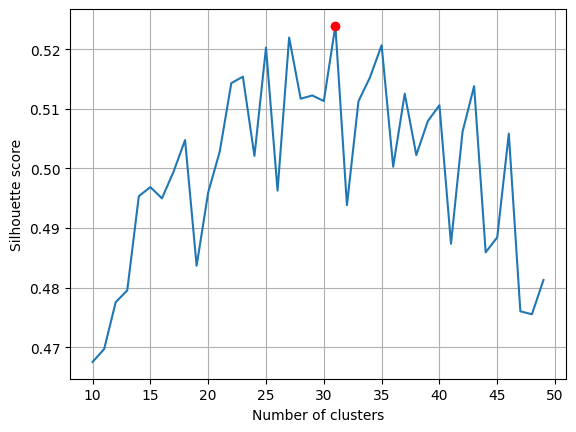

El valor apropiado de clusters es de: 31
El Silhouette score es de: 0.5239182050011443


In [5]:
# Try different numbers of clusters
sil_scores = []
dom=range(10, 50)

# Este valor de estabilización lo tomo de la media de nucleos determinados por el IDEAM para el 2022
rng = np.random.RandomState(11)

for n_clusters in dom:
    kmeans = KMeans(n_clusters=n_clusters, random_state=rng).fit(coords)
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(coords, cluster_labels, metric='euclidean')
    sil_scores.append(sil_score)

indice=sil_scores.index(max(sil_scores))
n_clusters=dom[indice]

# Plot the silhouette score as a function of the number of clusters
plt.plot(dom, sil_scores)
plt.plot(n_clusters, max(sil_scores),'r',marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()

print(f'El valor apropiado de clusters es de: {n_clusters}')
print(f'El Silhouette score es de: {max(sil_scores)}')

## Determinando los clusters

In [6]:
# Ejecutar el algoritmo K-means
kmeans = KMeans(n_clusters=n_clusters).fit(coords)

# Agregar las etiquetas de los clusters al GeoDataFrame
gdf['cluster'] = kmeans.labels_

# Verificar el CRS del GeoDataFrame
print("CRS antes:", gdf.crs)

# Asignar o transformar el CRS si es necesario
if gdf.crs is None:
    gdf.set_crs(CRS.from_epsg(4326), inplace=True)  # Asigna un CRS si no está definido
else:
    gdf = gdf.to_crs(epsg=4326)  # Cambia a EPSG:4326 si es necesario

print("CRS después:", gdf.crs)

# Guardar el GeoDataFrame en un archivo shapefile con el CRS adecuado
gdf.to_file(f'{Carpeta_clusters}/Clustering_{Temporalidad}.shp')

c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_17064\469266265.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f'{Carpeta_clusters}/Clustering_{Temporalidad}.shp')
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Description' to 'Descriptio'
  ogr_write(


CRS antes: EPSG:4326
CRS después: EPSG:4326


## Determinando los centroides

In [7]:
# Agrupa los datos por la columna "cluster".
grouped = gdf.groupby('cluster')

# Crea una lista para almacenar los GeoDataFrames de centroides.
centroid_gdfs = []

# Itera a través de los grupos y calcula el centroide de cada uno.
for cluster, group in grouped:
    # Calcula el centroide de los elementos del grupo.
    centroid = group.unary_union.centroid
    
    # Crea un nuevo GeoDataFrame para el centroide de este grupo.
    centroid_gdf = gpd.GeoDataFrame({'Cluster': [cluster], 'geometry': [centroid]}, geometry='geometry', crs=gdf.crs)
    centroid_gdfs.append(centroid_gdf)

# Concatena todos los GeoDataFrames de centroides en uno solo.
centroid_gdf = pd.concat(centroid_gdfs, ignore_index=True)

# Verifica el CRS del GeoDataFrame de centroides.
print("CRS de los centroides:", centroid_gdf.crs)

# Si el CRS no está definido o es incorrecto, asigna o transforma el CRS.
if centroid_gdf.crs is None or centroid_gdf.crs != gdf.crs:
    centroid_gdf.set_crs(gdf.crs, inplace=True)

# Guarda el GeoDataFrame de centroides como un shapefile.
output_path = f'{Carpeta_centroide}/Centroides_{Temporalidad}.shp'
centroid_gdf.to_file(output_path)

Cluster=[]
CPR=[]
for i in range(0,n_clusters):
    Cluster.append(i)
    a=int(gdf[gdf['cluster']==i].shape[0])
    CPR.append(a)

# Registro de información
CantidadDePuntosPorCluster=pd.DataFrame()
CantidadDePuntosPorCluster['Cluster']=Cluster
CantidadDePuntosPorCluster['Cantidad de puntos']=CPR
CantidadDePuntosPorCluster['%']=round(CantidadDePuntosPorCluster['Cantidad de puntos']/gdf.shape[0]*100,2)
CantidadDePuntosPorCluster=CantidadDePuntosPorCluster.sort_values('Cantidad de puntos',ascending=False )
CantidadDePuntosPorCluster.to_csv(f'ClustersYRegistros_{Temporalidad}.txt', sep='\t', index=False)

CRS de los centroides: EPSG:4326


C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_17064\1688513246.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = group.unary_union.centroid


## Polígonos mínimos

In [8]:
PoligonosDeClusters=[]
for i in Cluster:
    Puntos=gdf[gdf['cluster']==i]
    convex_hull = Puntos.unary_union.convex_hull
    convex_hull = gpd.GeoDataFrame(geometry=[convex_hull], crs="EPSG:4326")
    PoligonosDeClusters.append(convex_hull)

Poligonos = gpd.GeoDataFrame(pd.concat(PoligonosDeClusters, ignore_index=True), crs="EPSG:4326")
Poligonos.to_file(f'{Carpeta_PoligonosMinimos}/PoligonosMinimos_{Temporalidad}.shp')

C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_17064\2069516606.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull = Puntos.unary_union.convex_hull
C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_17064\2069516606.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull = Puntos.unary_union.convex_hull
C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_17064\2069516606.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull = Puntos.unary_union.convex_hull
C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_17064\2069516606.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull = Puntos.unary_union.convex_hull
C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_1

## Distancias al centroide e histogramas

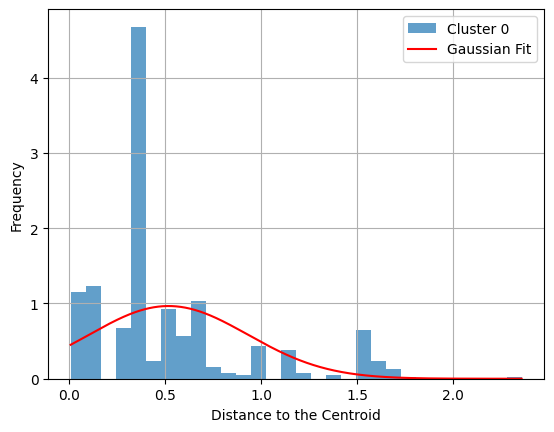

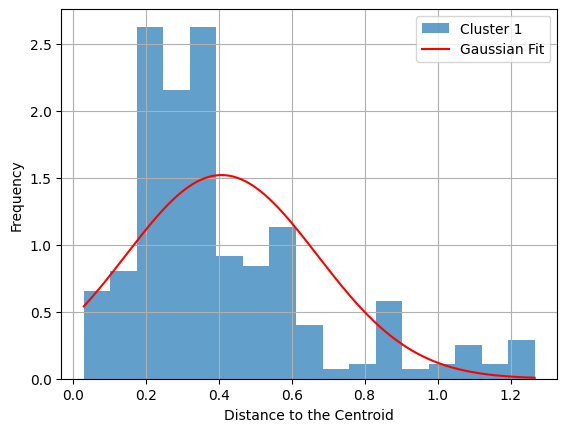

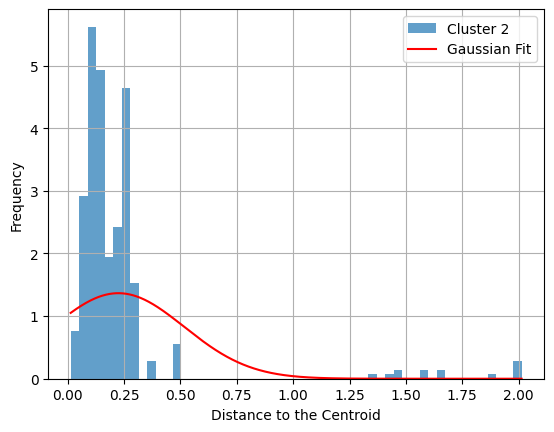

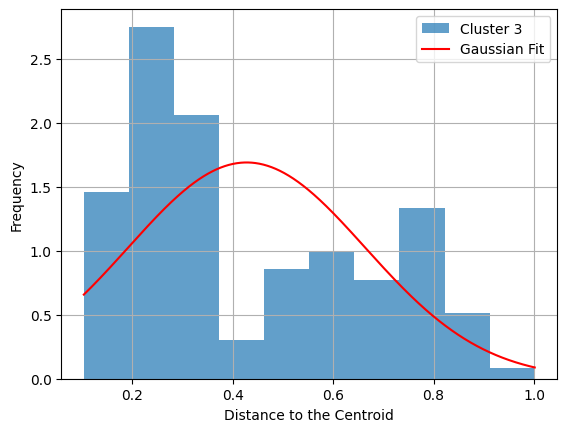

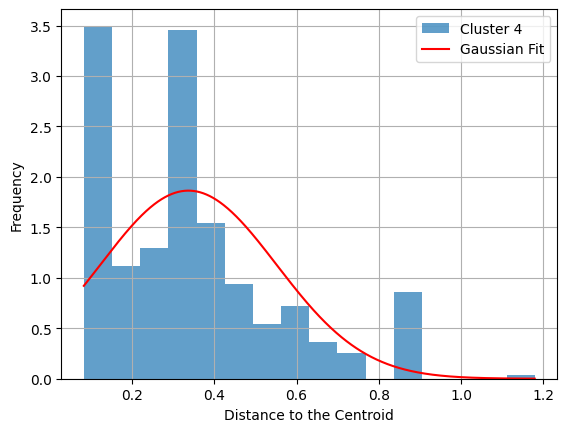

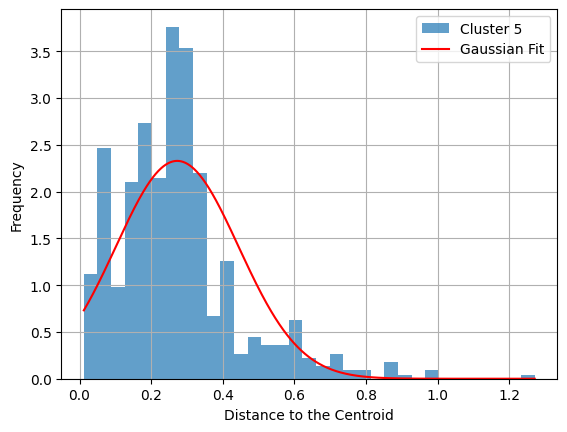

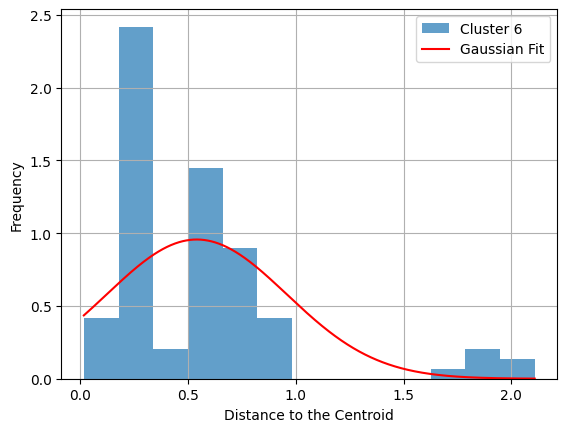

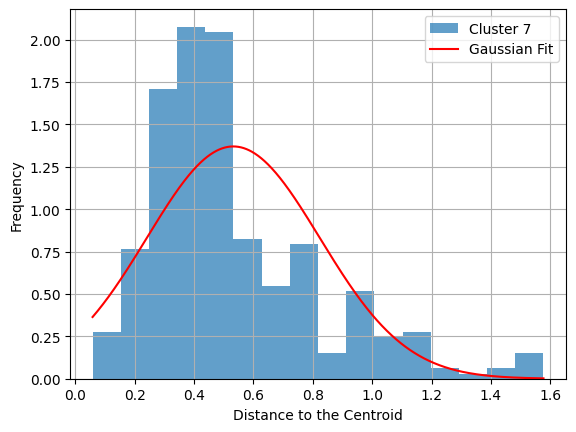

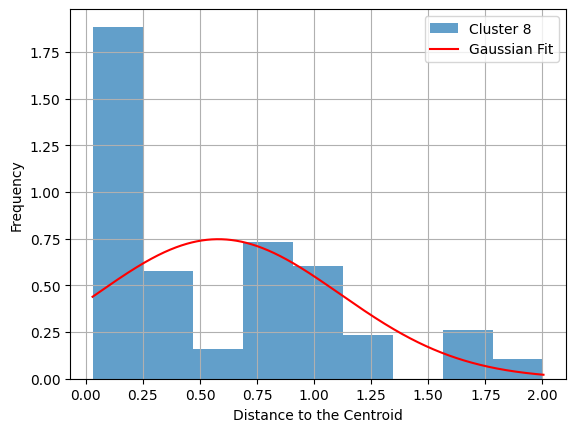

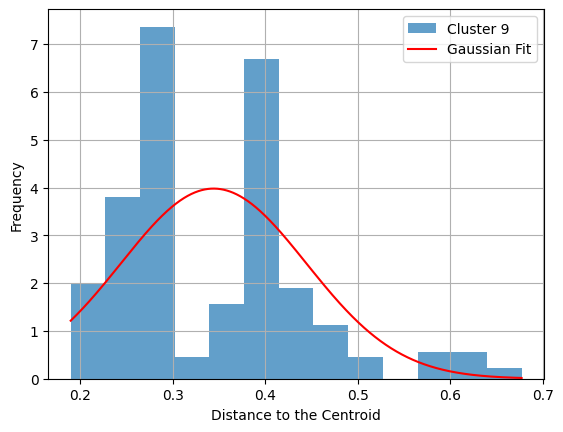

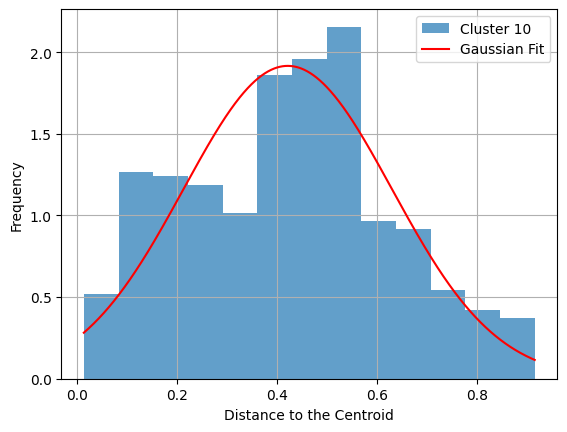

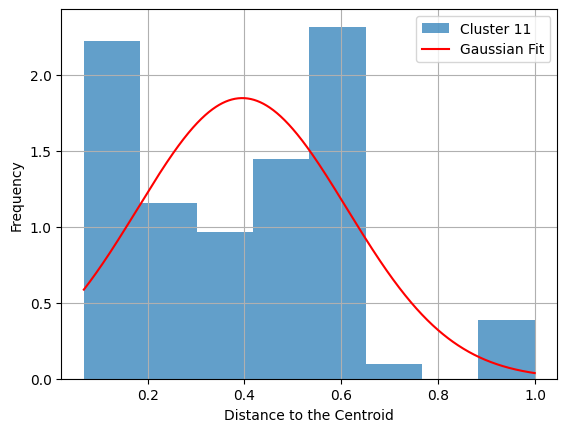

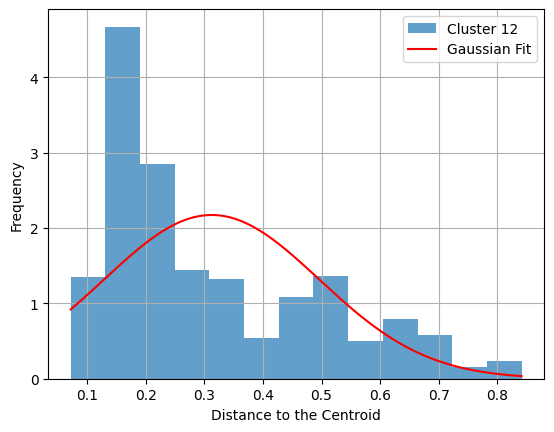

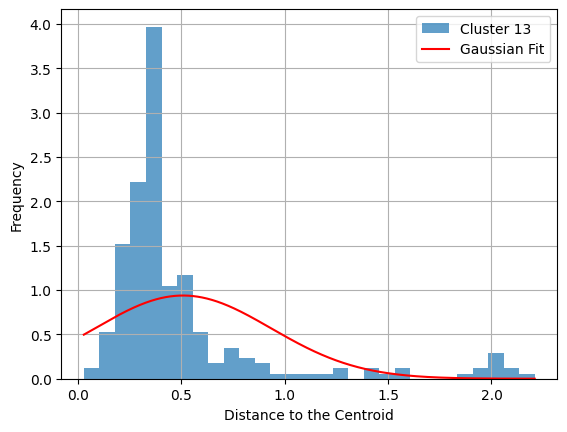

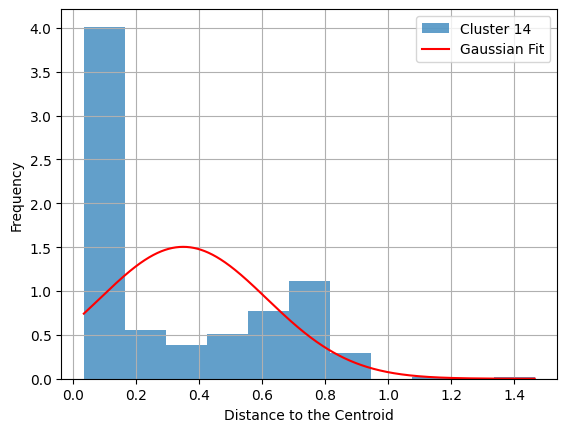

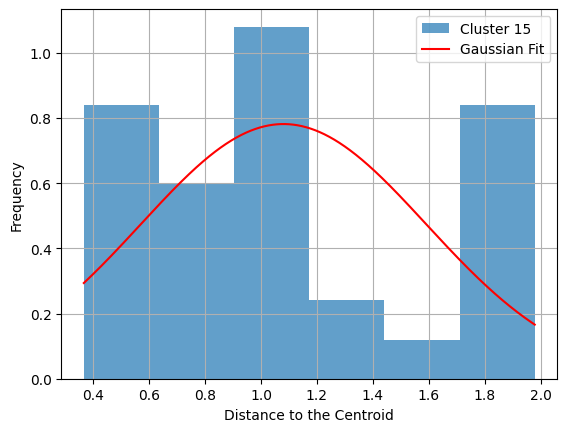

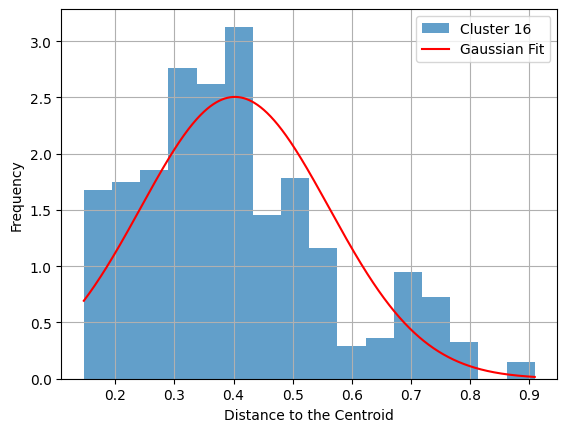

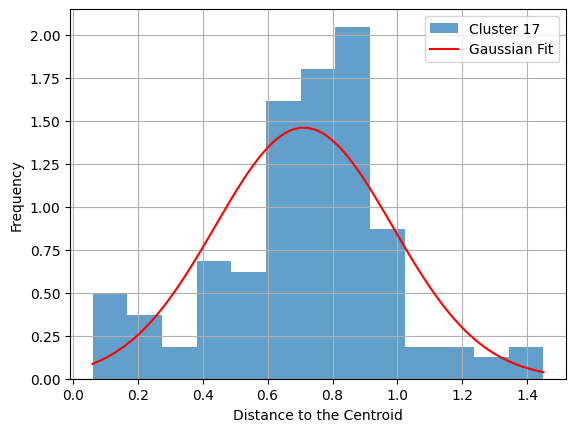

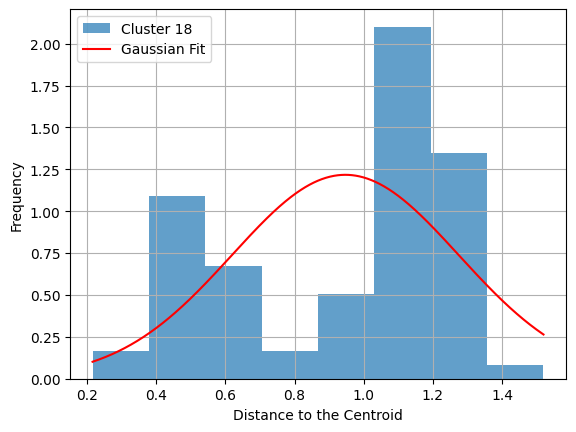

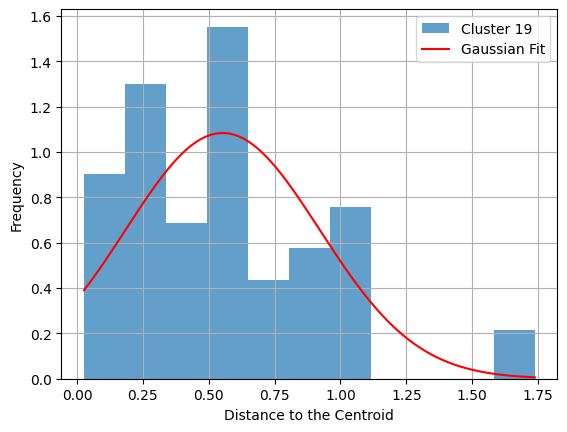

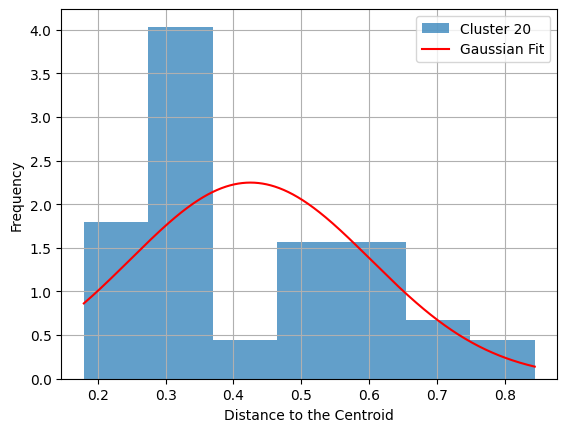

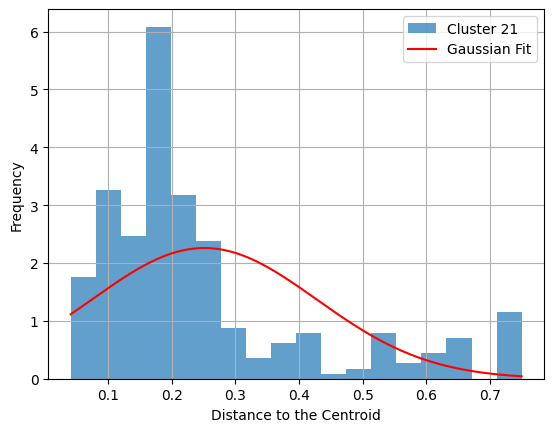

In [9]:
# Calculo de las distancias de los puntos a los centroides
gdf['distancia_al_centroide'] = gdf.apply(lambda row: row['geometry'].distance(centroid_gdf[centroid_gdf['Cluster'] == row['cluster']]['geometry'].values[0]), axis=1)

radios_r=[]
radios_R=[]

Sigma=[]
Mu=[]
error=[]

for cluster in range(0,centroid_gdf['Cluster'].shape[0]):
    cluster_data = gdf[gdf['cluster'] == cluster]['distancia_al_centroide']
    # Ajuste Gaussiano
    mu, std = norm.fit(cluster_data)
    # Crear un rango de valores para la curva ajustada
    x = np.linspace(min(cluster_data), max(cluster_data), 1000)
    # Calcular la PDF ajustada
    pdf_fit = norm.pdf(x, mu, std)

    fitted_values = norm.pdf(cluster_data, loc=mu, scale=std)

    # Asegurarse de que ambos conjuntos de datos tengan la misma longitud
    min_length = min(len(cluster_data), len(fitted_values))
    cluster_data = cluster_data[:min_length]
    fitted_values = fitted_values[:min_length]

    # Calcular el error cuadrático medio (MSE)
    mse = mean_squared_error(cluster_data, fitted_values)    

    # Determinando radios a partir del ajuste
    R=mu+std
    radios_R.append(R)
    r=mu-std
    radios_r.append(r)

    Mu.append(mu)
    Sigma.append(std)
    error.append(mse)

    # Graficas
    plt.hist(cluster_data, bins='auto', density=True, alpha=0.7, label=f'Cluster {cluster}')
    plt.plot(x, pdf_fit, 'r-', label='Gaussian Fit')
    # Configurar el gráfico
    plt.xlabel('Distance to the Centroid')
    plt.ylabel('Frequency')
    plt.grid()
    plt.legend()
    # Mostrar los histogramas
    plt.savefig(f'{Carpeta_Graficas}/Histograma de longitudes_Cluster {cluster}.png', dpi=300)
    plt.show()

centroid_gdf['Radio superior']=radios_R
centroid_gdf['Radio inferior']=radios_r

DelAjuste=pd.DataFrame()
DelAjuste['Sigma']=Sigma
DelAjuste['Mu']=Mu

## Consolidado de información

In [10]:
CI=pd.DataFrame()
CI['Cluster']=Cluster
CI['Cantidad de puntos']=CPR
CI['Areas de poligonos']=list(Poligonos.area)
CI['a']=CI['Cantidad de puntos']/CI['Areas de poligonos']
CI['Sigma']=Sigma
CI['Mu']=Mu
CI['MSE']=error
CI['varianza']=(CI['Sigma'])**2
CI['Energia promedio']=1/2*CI['varianza']*CI['a']
CI['Energia promedio normal']=CI['Energia promedio']/sum(CI['Energia promedio'])*100
CI.reset_index(drop=True)
CI.to_csv(f'DatosEstadisticos{Temporalidad}.csv')

C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_17064\2827141060.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  CI['Areas de poligonos']=list(Poligonos.area)


In [27]:

CI.index = Poligonos.index  # Asegura que los índices coincidan

# Realizar el merge utilizando el índice como columna común
gdf_merged = Poligonos.join(CI)
#df_top_10 = gdf_merged.sort_values(by="Cantidad de puntos", ascending=False).head(15).reset_index()
#df_top_10["Cluster"] = df_top_10.index

gdf_merged.to_file(f'{Carpeta_PoligonosMinimos}/NPoligonosMinimos_{Temporalidad}.shp')


C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_17064\4158749468.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_merged.to_file(f'{Carpeta_PoligonosMinimos}/NPoligonosMinimos_{Temporalidad}.shp')
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Cantidad de puntos' to 'Cantidad d'
  ogr_write(
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Areas de poligonos' to 'Areas de p'
  ogr_write(
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Energia promedio' to 'Energia pr'
  ogr_write(
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\py

In [29]:
gdf_merged.sort_values(by='a',ascending=False)

,geometry,Cluster,Cantidad de puntos,Areas de poligonos,a,Sigma,Mu,MSE,varianza,Energia promedio,Energia promedio normal
12,"POLYGON ((-74.23916 0.34329, -74.36867 0.51194...",12,853,1.099787,775.604544,0.183532,0.312532,1.853927,0.033684,13.062747,11.452525
21,"POLYGON ((-71.84061 1.36716, -71.84387 1.36786...",21,288,0.530047,543.348305,0.176576,0.251204,2.680255,0.031179,8.470562,7.426411
16,"POLYGON ((-73.47308 1.84263, -73.88193 1.88845...",16,577,1.087977,530.342221,0.159261,0.402259,2.494081,0.025364,6.725798,5.896720
5,"POLYGON ((-72.64298 7.72028, -72.76836 7.75942...",5,585,1.349444,433.512018,0.171360,0.272838,2.723309,0.029364,6.364885,5.580297
10,"POLYGON ((-75.84292 0.15075, -76.97355 0.29577...",10,582,1.605984,362.394705,0.208199,0.421853,1.145569,0.043347,7.854342,6.886152
9,"POLYGON ((-72.98272 2.16066, -72.98357 2.1617,...",9,239,0.693617,344.570711,0.100298,0.344174,7.154121,0.010060,1.733148,1.519505
4,"POLYGON ((-74.42735 2.27845, -74.49112 2.33527...",4,406,1.204079,337.187212,0.213999,0.337340,1.452133,0.045796,7.720848,6.769112
3,"POLYGON ((-74.63686 -0.32207, -74.70701 -0.299...",3,259,1.477617,175.282171,0.235871,0.427918,0.770900,0.055635,4.875916,4.274870
1,"POLYGON ((-75.17886 6.5636, -75.69954 6.59738,...",1,377,2.233064,168.826350,0.262535,0.407928,0.905142,0.068925,5.818160,5.100966
14,"POLYGON ((-75.27117 1.29002, -75.42374 1.30897...",14,318,2.176712,146.091915,0.265306,0.350313,0.730479,0.070387,5.141497,4.507714


## Circunferencias de probabilidad

In [227]:
# Crear una nueva columna con los círculos
centroid_gdf['Circulo R'] = centroid_gdf.apply(lambda row: row['geometry'].buffer(row['Radio superior']), axis=1)
centroid_gdf['Circulo r'] = centroid_gdf.apply(lambda row: row['geometry'].buffer(row['Radio inferior']), axis=1)
centroid_gdf['Energia promedio normal']=list(CI['Energia promedio normal'])
# Crear un GeoDataFrame con los círculos

circulos_R = gpd.GeoDataFrame(centroid_gdf[['Cluster', 'Circulo R','Energia promedio normal']], geometry='Circulo R')
circulos_r = gpd.GeoDataFrame(centroid_gdf[['Cluster', 'Circulo r','Energia promedio normal']], geometry='Circulo r')


# Guardar los círculos en un archivo tipo shape
circulos_R.to_file(f'{Carpeta_CirculosMáximos}/CM_{Temporalidad}.shp')
circulos_r.to_file(f'{Carpeta_CirculosMínimos}/Cm_{Temporalidad}.shp')

C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_15736\805210666.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  circulos_R.to_file(f'{Carpeta_CirculosMáximos}/CM_{Temporalidad}.shp')
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
c:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Energia promedio normal' to 'Energia pr'
  ogr_write(
C:\Users\jegonzalezb.PROCURADURIA\AppData\Local\Temp\ipykernel_15736\805210666.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  circulos_r.to_file(f'{Carpeta_CirculosMínimos}/Cm_{Temporalidad}.s

## Histogramas de ángulos

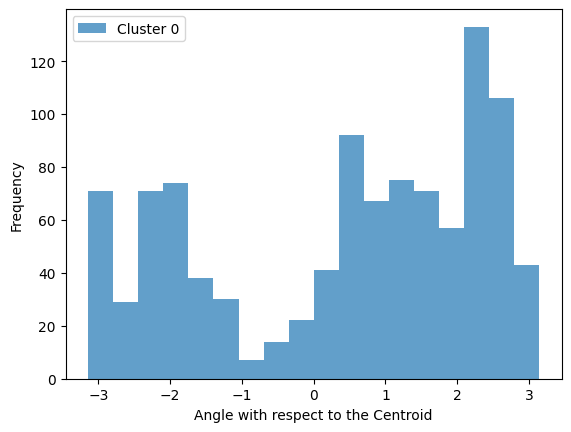

Para el cluster 1, el ángulo mínimo es -2.46 [rad], y el máximo es -2.13 [rad]
Para el cluster 1, el ángulo mínimo es -2.13 [rad], y el máximo es -1.8 [rad]


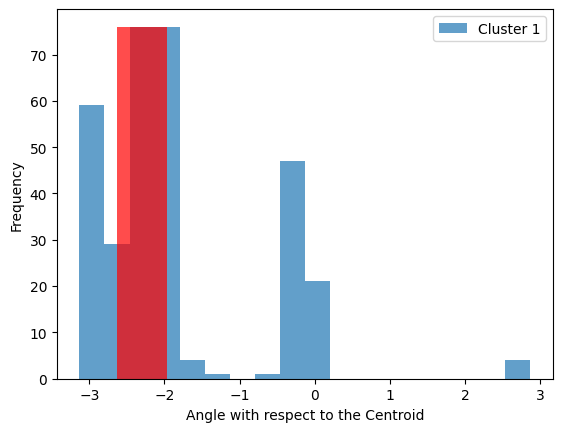

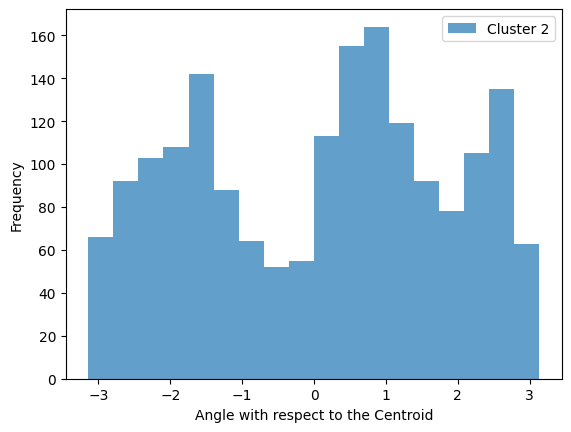

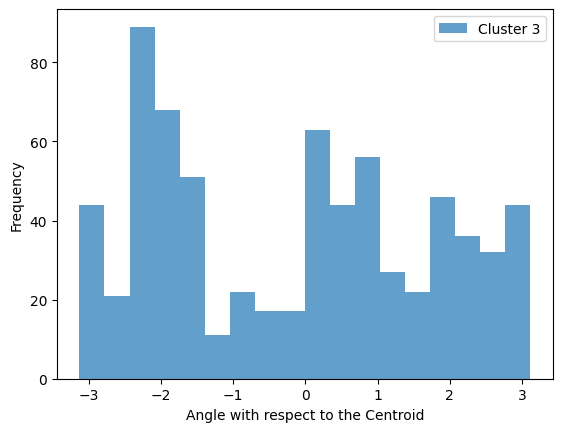

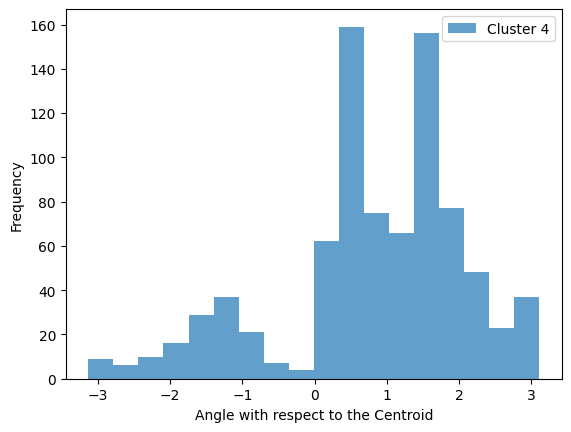

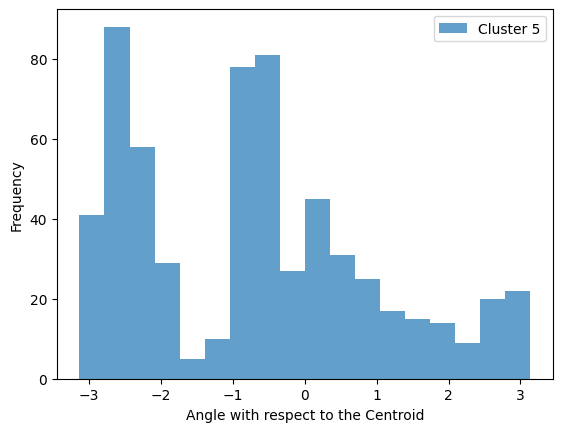

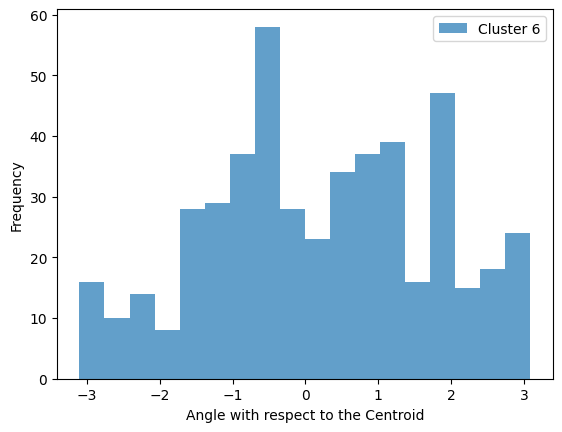

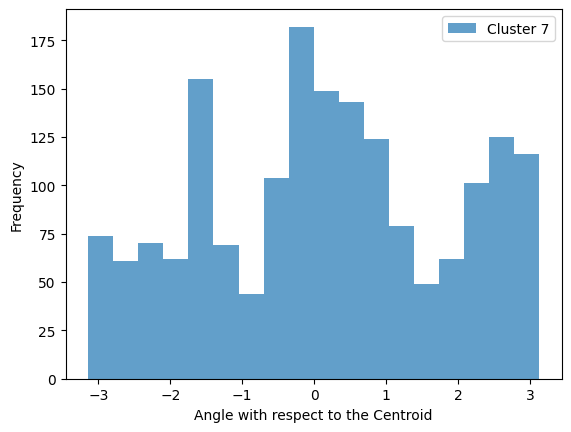

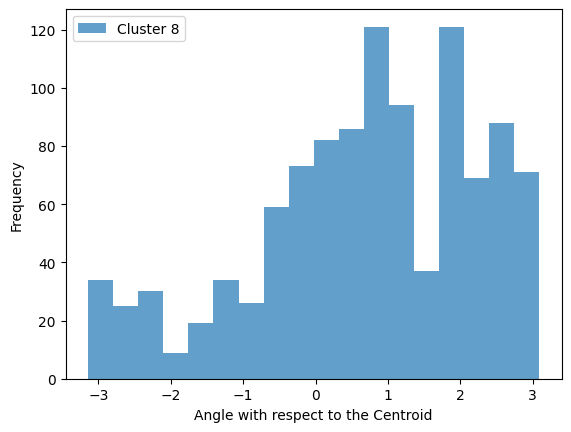

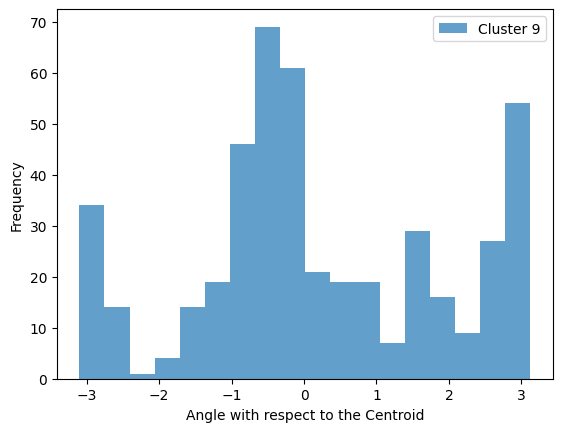

Para el cluster 10, el ángulo mínimo es 0.0 [rad], y el máximo es 0.35 [rad]


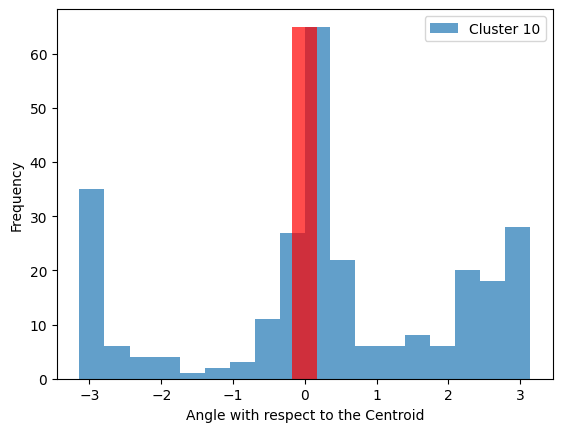

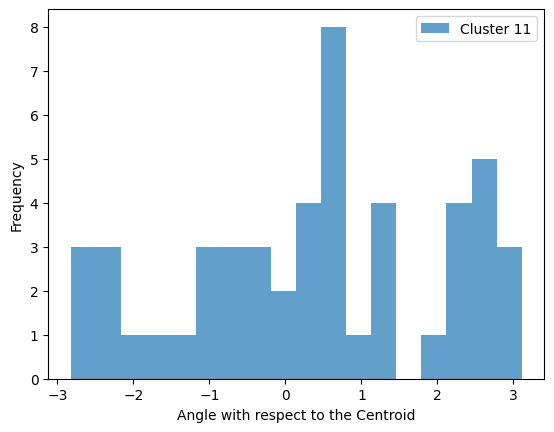

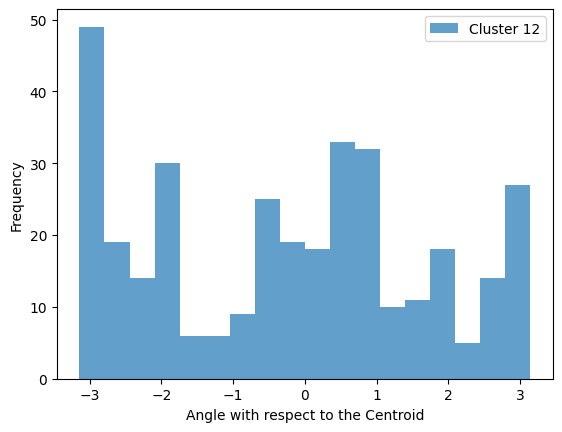

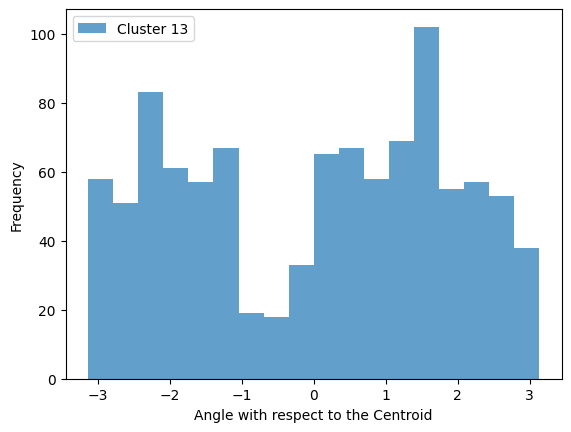

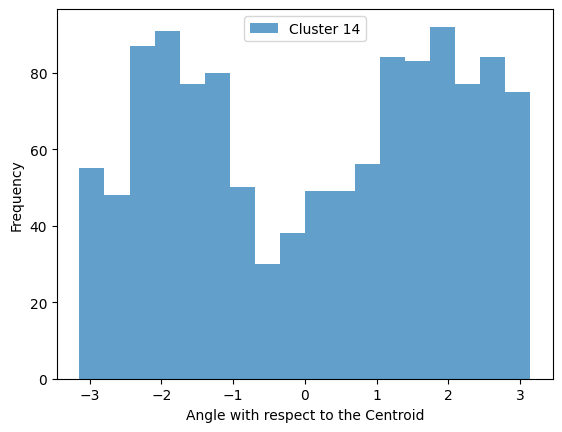

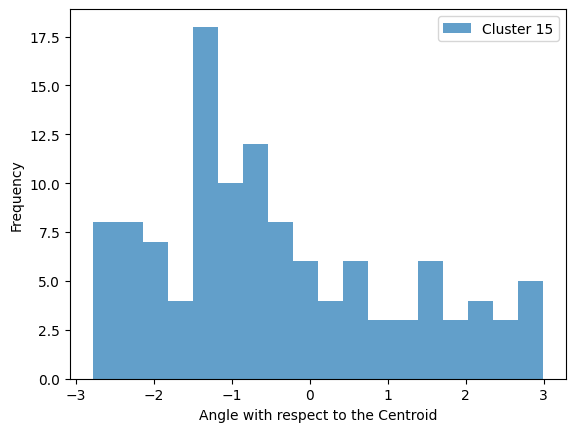

Para el cluster 16, el ángulo mínimo es -3.13 [rad], y el máximo es -2.78 [rad]
Para el cluster 16, el ángulo mínimo es -0.34 [rad], y el máximo es 0.0 [rad]


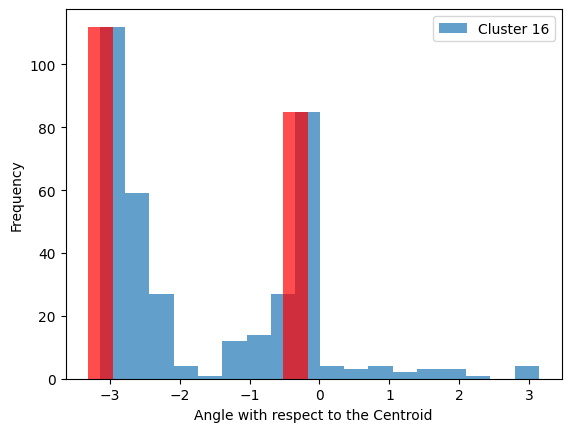

Para el cluster 17, el ángulo mínimo es -2.15 [rad], y el máximo es -1.88 [rad]


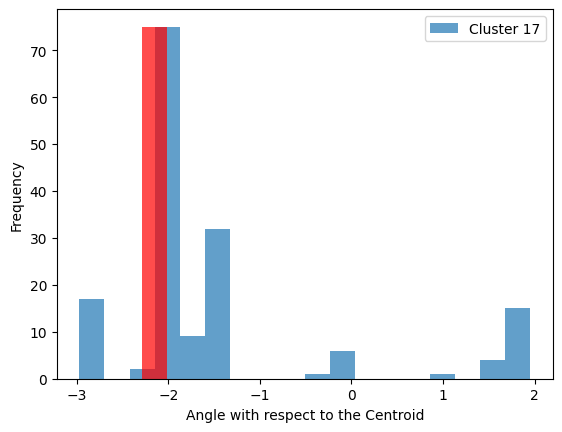

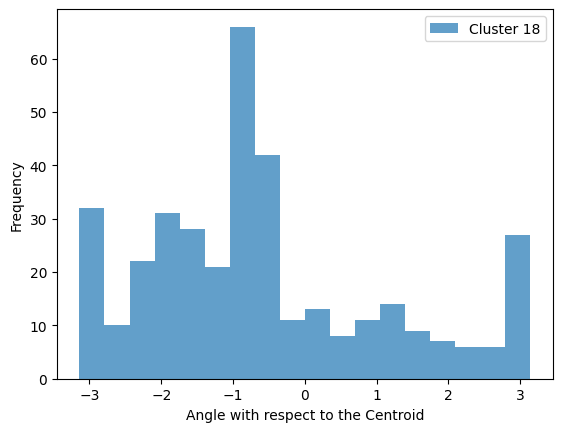

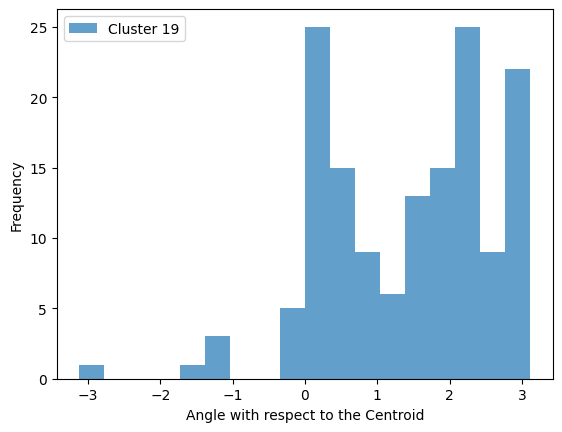

Para el cluster 20, el ángulo mínimo es 1.62 [rad], y el máximo es 1.96 [rad]


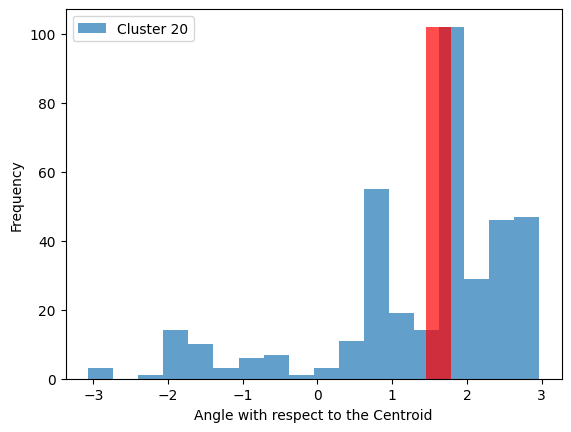

Para el cluster 21, el ángulo mínimo es -1.11 [rad], y el máximo es -1.05 [rad]


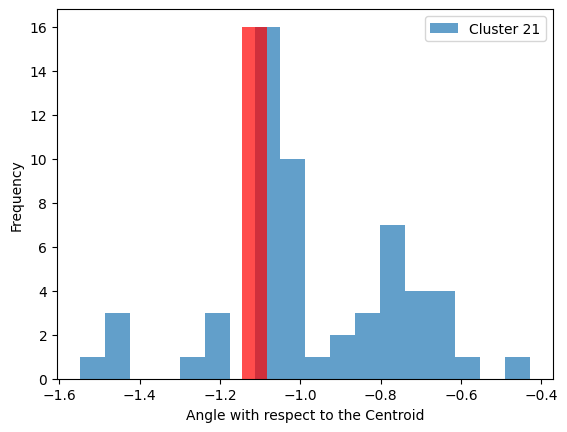

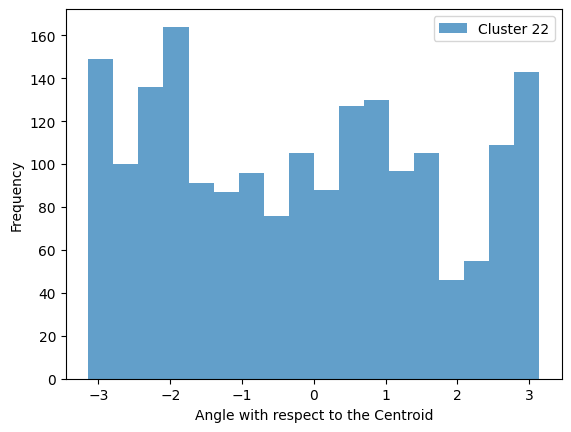

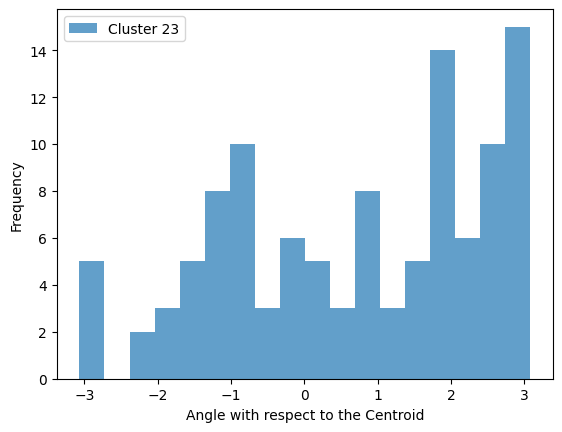

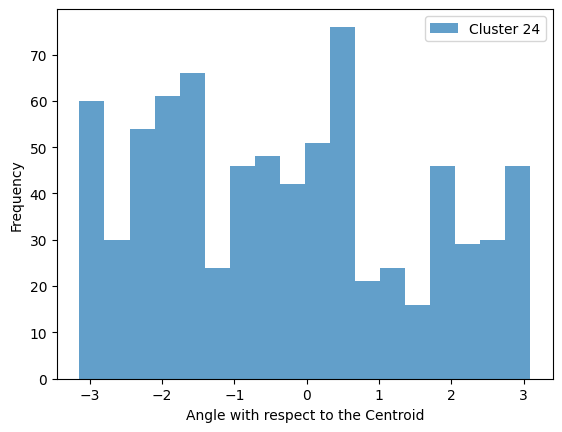

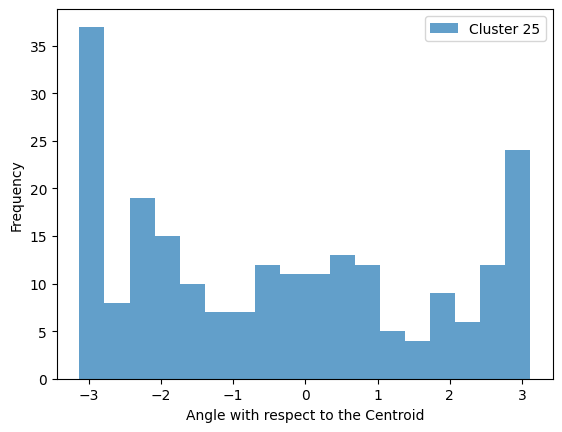

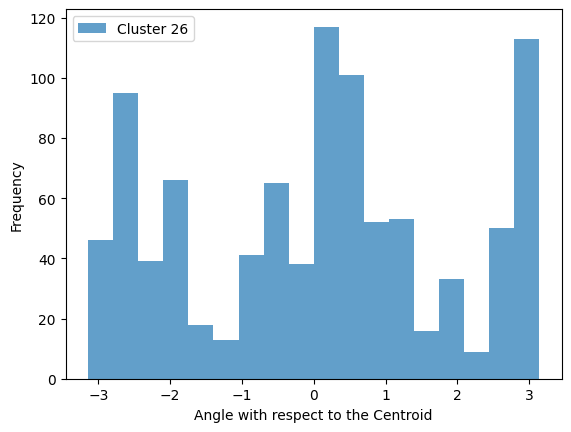

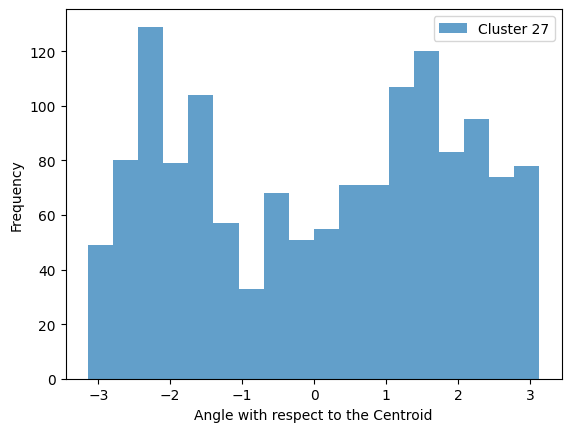

Para el cluster 28, el ángulo mínimo es -1.1 [rad], y el máximo es -1.04 [rad]


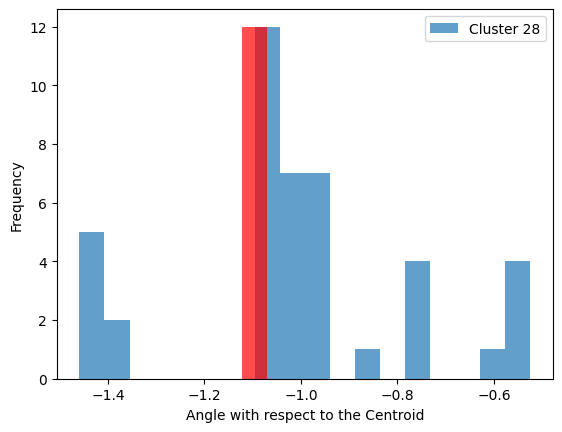

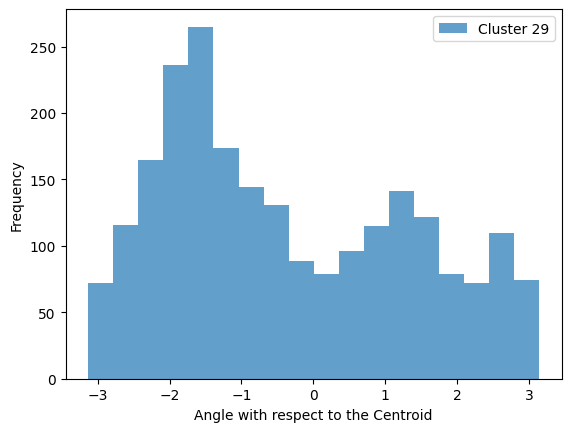

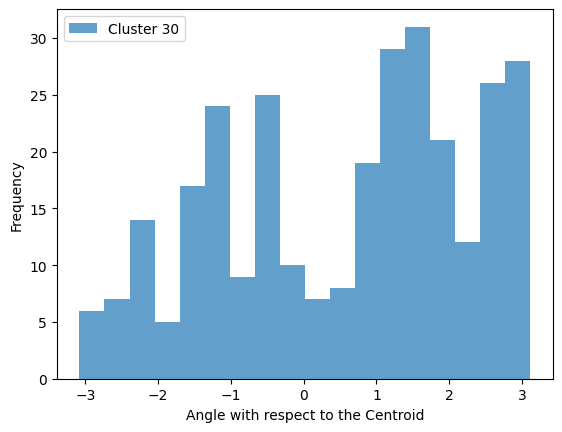

In [228]:
# En radianes
angles=[]

for clusters in range(0,centroid_gdf['Cluster'].shape[0]):
    for point in gdf[gdf['cluster'] == clusters]['geometry']: 
        centroid=centroid_gdf[centroid_gdf['Cluster'] == clusters]['geometry'].values[0]
        angle=np.arctan2(point.y - centroid.y, point.x - centroid.x)
        angles.append(angle)

gdf['Angulos respecto a su centroide']=angles

centroid_gdf['Ángulo máximo']=0.
centroid_gdf['Ángulo mínimo']=0.

for clusters in range(0, centroid_gdf['Cluster'].shape[0]):
    cluster_data = gdf[gdf['cluster'] == clusters]['Angulos respecto a su centroide']

    # Calcular el histograma
    frequencies, bin_edges, _ = plt.hist(cluster_data, bins=18, density=False, alpha=0.7, label=f'Cluster {clusters}')

    # Condición para cambiar el color
    threshold = (cluster_data.shape[0])/5
    
    for i in range(len(frequencies)):
        if frequencies[i] > threshold:

            ancho=bin_edges[i+1] - bin_edges[i]
            plt.bar(bin_edges[i], frequencies[i], width=ancho, alpha=0.7, color='red')

            centroid_gdf.iloc[clusters, centroid_gdf.columns.get_loc('Ángulo mínimo')]=bin_edges[i]
            centroid_gdf.iloc[clusters, centroid_gdf.columns.get_loc('Ángulo máximo')]=bin_edges[i]+ancho
            
            print(f"Para el cluster {clusters}, el ángulo mínimo es {round(bin_edges[i],2)} [rad], y el máximo es {round(bin_edges[i]+ancho,2)} [rad]")


    # Configurar el gráfico
    plt.xlabel('Angle with respect to the Centroid')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{Carpeta_Graficas}/Histograma de Angulos_Cluster {clusters}.png', dpi=300)
    # Mostrar los histogramas
    plt.show()   

centroid_gdf['Radio medio']=(centroid_gdf['Radio superior']+centroid_gdf['Radio inferior'])/2
centroid_gdf['Ángulo medio']=(centroid_gdf['Ángulo máximo']+centroid_gdf['Ángulo mínimo'])/2

## Creación de vectores de ángulos preferentes

In [229]:
# Asegurarse de que el GeoDataFrame tiene el CRS correcto antes de operar
# Si el CRS original es conocido pero no está establecido:
if centroid_gdf.crs is None:
    # Por ejemplo, si las coordenadas son WGS84:
    centroid_gdf.set_crs(epsg=4326, inplace=True)
    
# Si se necesita proyectar a un CRS específico para análisis en Colombia:
centroid_gdf = centroid_gdf.to_crs(epsg=3116)  # CRS proyectado de Colombia

def create_lines(row):
    x0, y0 = row['geometry'].x, row['geometry'].y
    angulo = row['Ángulo medio']
    radio = row['Radio medio']
    
    # Calcular las coordenadas finales de la línea
    x1 = x0 + radio * np.cos(angulo)
    y1 = y0 + radio * np.sin(angulo)
    
    # Crear la geometría LineString
    return LineString([(x0, y0), (x1, y1)])

centroid_gdf['linea'] = centroid_gdf.apply(create_lines, axis=1)
lineas = centroid_gdf[centroid_gdf['Ángulo medio'] != 0]
Lineas = gpd.GeoDataFrame(lineas[['Cluster', 'linea']], geometry='linea', crs=centroid_gdf.crs)

# Guardar el shapefile en el CRS correcto
Lineas.to_file(f'{Carpeta_LineasDeTendencia}/LineasDeTendencia_{Temporalidad}.shp')

In [230]:
años=['2020','2021','2022']
q=['i','ii','iii','iv']
EP=[]

for i in años:
    for  j in q:
        T=pd.read_csv(f'DatosEstadisticos{i}{j}.csv')
        ep=T['Energia promedio'].mean().round(2)
        EP.append(ep)

q=['i','ii','iii']

for  j in q:
    T=pd.read_csv(f'DatosEstadisticos2023{j}.csv')
    ep=T['Energia promedio'].mean().round(2)
    EP.append(ep)

promedios = [sum(EP[i:i+4]) / 4 for i in range(0, len(EP)-3, 4)]
promedios.append(sum(EP[12:15]) / 3)

A=list(promedios/max(promedios))

In [231]:
años=['2020','2021','2022']
q=['i','ii','iii','iv']
Z=[]

for i in años:
    for  j in q:
        T=pd.read_csv(f'DatosEstadisticos{i}{j}.csv')
        a=T['Cantidad de puntos'].sum()
        EP.append(ep)

q=['i','ii','iii']

for  j in q:
    T=pd.read_csv(f'DatosEstadisticos2023{j}.csv')
    ep=T['Energia promedio'].mean().round(2)
    EP.append(ep)

promedios = [sum(EP[i:i+4]) / 4 for i in range(0, len(EP)-3, 4)]
promedios.append(sum(EP[12:15]) / 3)

A=list(promedios/max(promedios))

# Analisis de resultados

In [232]:
años=['2020','2021','2022']
q=['i','ii','iii','iv']
EP=[]
TP=[]

for i in años:
    for  j in q:
        T=pd.read_csv(f'DatosEstadisticos{i}{j}.csv')
        ep=T['Energia promedio'].mean().round(2)
        tp=T['Cantidad de puntos'].sum()
        EP.append(ep)
        TP.append(tp)

q=['i','ii','iii']

for  j in q:
    T=pd.read_csv(f'DatosEstadisticos2023{j}.csv')
    ep=T['Energia promedio'].mean().round(2)
    tp=T['Cantidad de puntos'].sum()
    EP.append(ep)
    TP.append(tp)

promedios = [sum(EP[i:i+4]) / 4 for i in range(0, len(EP)-3, 4)]
promedios.append(sum(EP[12:15]) / 3)

A=list(promedios/max(promedios))
B=list(TP/max(TP))

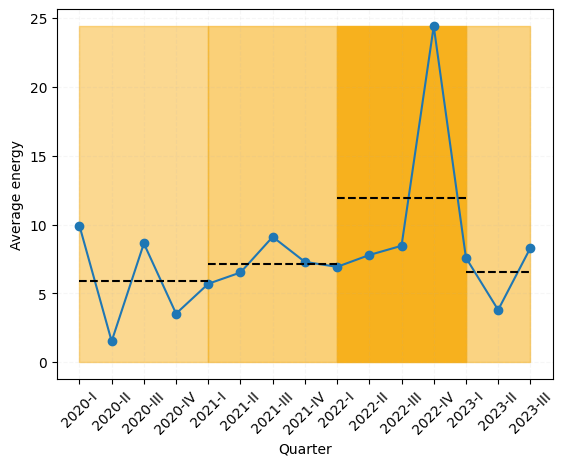

In [233]:
t=['2020-I','2020-II','2020-III','2020-IV',
    '2021-I','2021-II','2021-III','2021-IV',
   '2022-I','2022-II','2022-III','2022-IV',
   '2023-I','2023-II','2023-III',]

plt.plot(t,EP, marker='o')

plt.plot(t[0:5],[promedios[0]]*5, linestyle='--',color='k')
plt.plot(t[4:9],[promedios[1]]*5, linestyle='--',color='k')
plt.plot(t[8:13],[promedios[2]]*5, linestyle='--',color='k')
plt.plot(t[12:15],[promedios[3]]*3, linestyle='--',color='k')

y_min = 0
y_max = max(EP)
plt.fill_between(x=['2020-I', '2021-I'], y1=y_min, y2=y_max, color='#F7B11E', alpha=A[0])
plt.fill_between(x=['2021-I', '2022-I'], y1=y_min, y2=y_max, color='#F7B11E', alpha=A[1])
plt.fill_between(x=['2022-I', '2023-I'], y1=y_min, y2=y_max, color='#F7B11E', alpha=A[2])
plt.fill_between(x=['2023-I', '2023-III'], y1=y_min, y2=y_max, color='#F7B11E', alpha=A[3])

plt.xticks(t, rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Average energy')
plt.grid(alpha=0.1, linestyle='--')
plt.show()

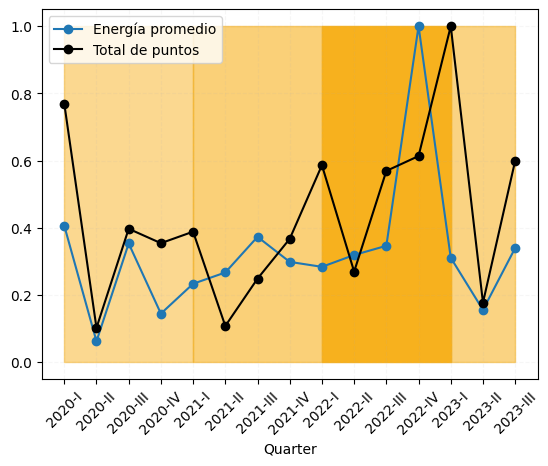

In [234]:
t=['2020-I','2020-II','2020-III','2020-IV',
    '2021-I','2021-II','2021-III','2021-IV',
   '2022-I','2022-II','2022-III','2022-IV',
   '2023-I','2023-II','2023-III',]

plt.plot(t,EP/max(EP), marker='o',label='Energía promedio')
plt.plot(t,TP/max(TP), marker='o',label='Total de puntos', color='k')

y_min = 0
y_max = 1
plt.fill_between(x=['2020-I', '2021-I'], y1=y_min, y2=y_max, color='#F7B11E', alpha=A[0])
plt.fill_between(x=['2021-I', '2022-I'], y1=y_min, y2=y_max, color='#F7B11E', alpha=A[1])
plt.fill_between(x=['2022-I', '2023-I'], y1=y_min, y2=y_max, color='#F7B11E', alpha=A[2])
plt.fill_between(x=['2023-I', '2023-III'], y1=y_min, y2=y_max, color='#F7B11E', alpha=A[3])

plt.xticks(t, rotation=45)
plt.xlabel('Quarter')
plt.grid(alpha=0.1, linestyle='--')
plt.legend()
plt.show()

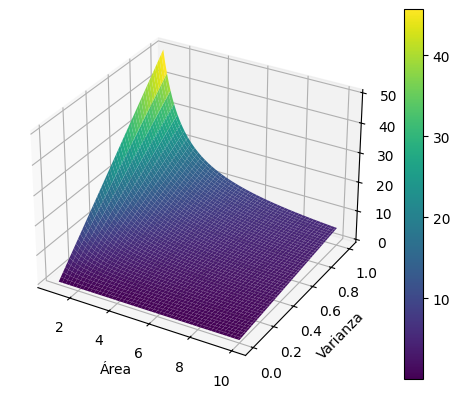

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define tu función de tres variables, por ejemplo, f(x, y) = x^2 + y^2
def f(a, var):
    return (1/2)*(100/a)*var

# Genera los puntos (x, y) sobre una malla
a = np.linspace(1, 10, 100)
var = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(a, var)

# Calcula los valores de Z basados en la malla de puntos (x, y)
Z = f(X, Y)

# Crea la figura y el eje para la gráfica 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grafica la superficie
surface = ax.plot_surface(X, Y, Z, cmap='viridis')  # 'viridis' es un mapa de colores. Puedes elegir otro.

# Añade etiquetas y muestra la gráfica
ax.set_xlabel('Área')
ax.set_ylabel('Varianza')
ax.set_zlabel('Energía')

# Opción para añadir una barra de colores que muestre la escala de valores de Z
fig.colorbar(surface)

plt.show()
